<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/ADL_lab_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch as th
import torch.nn as nn
import torch.optim as optim


from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
device='cpu'
if th.cuda.is_available():
    device='cuda'

# First attack

## The  pre-trained model
To test adversarial attacks, we will use a pre-trained model. Pytorch comes with many pretrained models for different tasks. For more details look at [this web page](https://pytorch.org/vision/stable/models.html).   These are easy to load and to use.  For instance here, we will take one of the smallest: ResNet18.

In [6]:
# Load a ResNet model (DEFAULT is an alias for the best available weights
# If weigths = None, the parameters are randomly initialized and you need
# to train the model from scratch.
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## An image to attack

Let us consider the following image (get the pig.jpg or an image of your choice). We first need to transform this image properly. The model was trained on the ImageNet dataset: all the images are expected to be normalized and of fixed size (224x224).



In [7]:
# A simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = th.Tensor(mean)
        self.std = th.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# And for the dimensions
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])

Now we can load an image and apply these transformations. Normalization is only applied for the model.  

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
folder_path = 'drive/MyDrive/DL/'

In [10]:
pig_img = Image.open(f"{folder_path}pig.jpg")
pig_tensor = preprocess(pig_img)[None,:,:,:]
oninou = Image.open(f"{folder_path}oninou.jpg")
ninou_tensor = preprocess(oninou)[None, :, :]

Look at the image. Since numpy use  HWC (Height, Width, Channels) whereas Pytorch user CHW, we use a small function.

In [11]:
def plot_tensor(t):
    plt.imshow(t[0].detach().numpy().transpose(1,2,0))

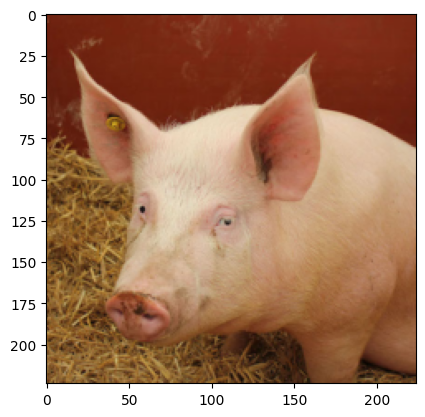

In [12]:
plot_tensor(pig_tensor)

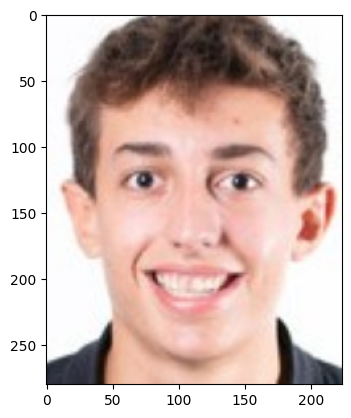

In [13]:
plot_tensor(ninou_tensor)

## What is the prediction of the model ?
ImageNet is a dataset with 1000 classes. To make the link between the id of the class and its associated name, we need to load tha mapping.

In [14]:
import json
with open(f"{folder_path}imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

print("We have",len(imagenet_classes), " classes")
for i in np.random.randint(0,1000,10):
    print("class", i , " is a ", imagenet_classes[i])

We have 1000  classes
class 79  is a  centipede
class 849  is a  teapot
class 73  is a  barn_spider
class 322  is a  ringlet
class 865  is a  toyshop
class 625  is a  lifeboat
class 85  is a  quail
class 52  is a  thunder_snake
class 108  is a  sea_anemone
class 787  is a  shield


In [15]:
pred = model(ninou_tensor) # 1 image, 1000 classes : 1,1000
classid = pred.max(dim=1)[1].item()
print("The predicted class is ",classid, " i.e a ", imagenet_classes[classid], " with the score ", pred[0][classid])
lossf = nn.CrossEntropyLoss()
softmax = nn.functional.softmax
l = lossf(pred,th.LongTensor([classid]))
print("The loss is ", l.item() ," and the prob is ", softmax(pred[0],dim=0)[classid].item())

print("ONINOU LE NOEUD PAPILLON")

The predicted class is  457  i.e a  bow_tie  with the score  tensor(9.4661, grad_fn=<SelectBackward0>)
The loss is  0.969842255115509  and the prob is  0.3791428208351135
ONINOU LE NOEUD PAPILLON


In [16]:
pred = model(pig_tensor) # 1 image, 1000 classes : 1,1000
classid = pred.max(dim=1)[1].item()
print("The predicted class is ",classid, " i.e a ", imagenet_classes[classid], " with the score ", pred[0][classid])

The predicted class is  341  i.e a  hog  with the score  tensor(19.2588, grad_fn=<SelectBackward0>)


Good ! In ImageNet there is only one class for pigs and hogs. So the prediction is correct. Look at the loss:

In [17]:
lossf = nn.CrossEntropyLoss()
softmax = nn.functional.softmax
l = lossf(pred,th.LongTensor([classid]))
print("The loss is ", l.item() ," and the prob is ", softmax(pred[0],dim=0)[classid].item())

The loss is  0.004019516054540873  and the prob is  0.9959885478019714


The model is very confident in its decision. The second best class has at most a probability of 0.004 !

# Creating an adversarial example

To create an adversarial example, we will use the PGD (projected gradient descent). As a reminder, we add a small perturbation to the image to maximize the loss. Therefore,  the new optimization problem is:
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(f_\theta(\hat{x}), y)
\end{equation}
where  $\hat{x}$ denotes our adversarial example  attempting to maximize the loss $\ell$ and to fool the model $f_\theta$.  

This optimization must be constrained !  We cannot change the image entirely, say to a dog. We want to ensure that $\hat{x}$ is close to our original input $x$. By convention, we typically do this by optimizing over the perturbation to $x$, which we will denote $\delta$
\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}
where $\Delta$ represents an allowable set of perturbations (typically perturbation that make $x + \tau$ sufficiently close to $x$).  

Characterizing the "correct" set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the "same" as the original input $x$.  This can include:  adding slight amounts of noise, rotating, translating, scaling, ...
A common perturbation is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is a slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  

**TODO**:
- Implement the PGD attack on this image.
- Try different values for epsilon to see the difference
- Compare the original image with the attack.


In [80]:
# PGD attack on the image
def pgd_attack(pig_tensor, epsilon = 2/128, lr = 1, maxiter = 10):
  delta = th.zeros_like(pig_tensor, requires_grad = True)
  perturbed_tensor = pig_tensor + delta
  optimizer = optim.SGD([delta], lr = lr)
  optimizer.zero_grad()
  pred_init = model(perturbed_tensor)
  classid_init = pred_init.max(dim = 1)[1].item()
  classid_perturb = classid_init
  compt = 0
  attacks = [perturbed_tensor]
  for i in range(maxiter):
    optimizer.zero_grad()
    perturbed_tensor = th.clamp(pig_tensor+ delta, 0, 1)
    pred =  model(perturbed_tensor)
    attacks.append(perturbed_tensor)
    classid_perturb = pred.max(dim = 1)[1].item()
    print("The predicted class is ",classid_perturb, " i.e a ", imagenet_classes[classid_perturb], " with the score ", pred[0][classid_perturb])
    loss = -lossf(pred, th.LongTensor([classid]))
    print(compt, loss)
    if classid_perturb != classid_init:
      break
    loss.backward(retain_graph=True)
    optimizer.step()
    compt += 1
    delta.data.clamp(-epsilon, epsilon)
  return attacks, delta



attacks = pgd_attack(pig_tensor)

The predicted class is  341  i.e a  hog  with the score  tensor(19.2588, grad_fn=<SelectBackward0>)
0 tensor(-0.0040, grad_fn=<NegBackward0>)
The predicted class is  341  i.e a  hog  with the score  tensor(18.1875, grad_fn=<SelectBackward0>)
1 tensor(-0.0086, grad_fn=<NegBackward0>)
The predicted class is  341  i.e a  hog  with the score  tensor(15.9658, grad_fn=<SelectBackward0>)
2 tensor(-0.0780, grad_fn=<NegBackward0>)
The predicted class is  719  i.e a  piggy_bank  with the score  tensor(17.7673, grad_fn=<SelectBackward0>)
3 tensor(-12.3255, grad_fn=<NegBackward0>)


What does it look like ?


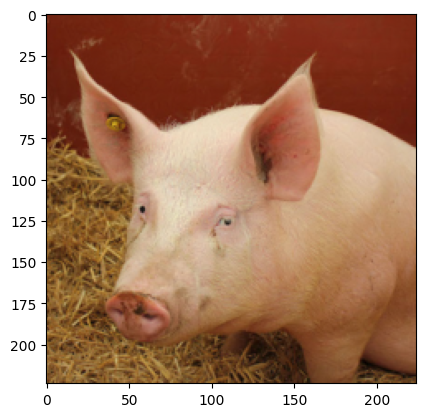

In [82]:
# look at the corrupted image
plot_tensor(attacks[0][-1])

Look at the noise alone.

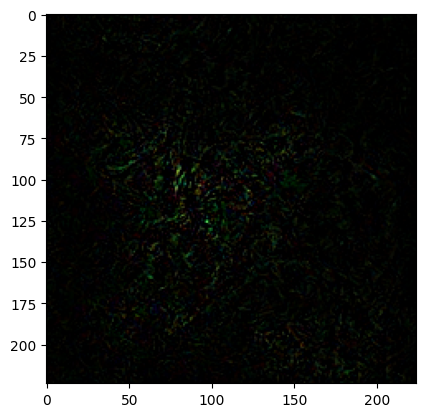

In [84]:
# plot the noise image
delta = attacks[1]
plot_tensor(delta*1e1)

# Targeted attacks: when pigs can fly

This is impressive, but we can do better. This same method can be used to make the image classified as what  we want.  This is a "targeted attack".  Instead of trying to just maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.  

**TODO**:
- Write the new optimization program
- Implement and test it

For instance, try to target the class 404.

In [97]:
def pgd_attack_target(pig_tensor, epsilon = 2/128, lr = 1, maxiter = 10, targeted_class = 404):
  delta = th.zeros_like(pig_tensor, requires_grad = True)
  perturbed_tensor = pig_tensor + delta
  optimizer = optim.SGD([delta], lr = lr)
  optimizer.zero_grad()
  pred_init = model(perturbed_tensor)
  classid_init = pred_init.max(dim = 1)[1].item()
  classid_perturb = classid_init
  compt = 0
  attacks = [perturbed_tensor]
  for i in range(maxiter):
    optimizer.zero_grad()
    perturbed_tensor = th.clamp(pig_tensor+ delta, 0, 1)
    pred =  model(perturbed_tensor)
    attacks.append(perturbed_tensor)
    classid_perturb = pred.max(dim = 1)[1].item()
    print("The predicted class is ",classid_perturb, " i.e a ", imagenet_classes[classid_perturb], " with the score ", pred[0][classid_perturb])
    loss = -lossf(pred, th.LongTensor([classid])) + lossf(pred, th.LongTensor([targeted_class]))
    print(compt, loss)
    if classid_perturb == targeted_class:
      print('a')
      break
    loss.backward(retain_graph=True)
    optimizer.step()
    compt += 1
    delta.data.clamp(-epsilon, epsilon)
  return attacks, delta


The predicted class is  341  i.e a  hog  with the score  tensor(19.2588, grad_fn=<SelectBackward0>)
0 tensor(21.5999, grad_fn=<AddBackward0>)
The predicted class is  719  i.e a  piggy_bank  with the score  tensor(8.9203, grad_fn=<SelectBackward0>)
1 tensor(3.7939, grad_fn=<AddBackward0>)
The predicted class is  908  i.e a  wing  with the score  tensor(9.7325, grad_fn=<SelectBackward0>)
2 tensor(-9.5247, grad_fn=<AddBackward0>)
The predicted class is  908  i.e a  wing  with the score  tensor(17.7530, grad_fn=<SelectBackward0>)
3 tensor(-20.9710, grad_fn=<AddBackward0>)
The predicted class is  908  i.e a  wing  with the score  tensor(21.0379, grad_fn=<SelectBackward0>)
4 tensor(-26.0636, grad_fn=<AddBackward0>)
The predicted class is  908  i.e a  wing  with the score  tensor(24.4986, grad_fn=<SelectBackward0>)
5 tensor(-27.3852, grad_fn=<AddBackward0>)
The predicted class is  908  i.e a  wing  with the score  tensor(27.8834, grad_fn=<SelectBackward0>)
6 tensor(-32.4607, grad_fn=<AddBackw

Text(0.5, 1.0, 'Noise image')

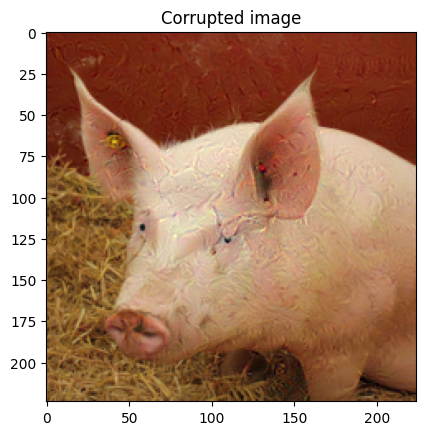

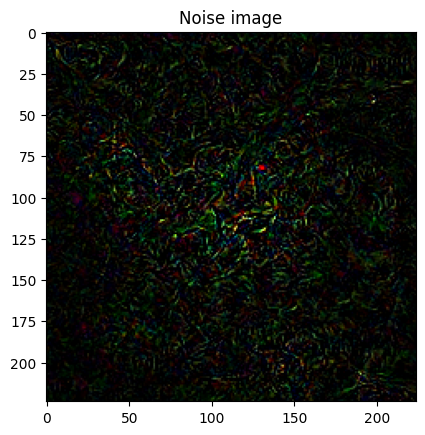

In [90]:
attacks = pgd_attack_target(pig_tensor, lr = 1e-1, maxiter = 10, targeted_class = 404)
# look at the corrupted image
plt.figure()
plot_tensor(attacks[0][-1])
plt.title('Corrupted image')

# plot the noise image
delta = attacks[1]
plt.figure()
plot_tensor(delta*5)
plt.title('Noise image')

# Robustness evaluation

Take a ResNet model that you trained on CIFAR10 and evaluate it on the test set, with and without PGD attack. If you don't have a pre-trained resnet you can use a simple CNN (see on moodle).

In [91]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 200

trainset_1 = th.utils.data.Subset(trainset, range(20000))

trainloader = th.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 42909370.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [230]:
CNN_Model = nn.Sequential(nn.Conv2d(3, 6, 5, padding=2),
                          nn.ReLU(),
                          nn.MaxPool2d(2),
                          nn.Conv2d(6, 32, 5),
                          nn.ReLU(),
                          nn.MaxPool2d(2),
                          nn.Flatten(),
                          nn.Linear(2*576, 120),
                          nn.ReLU(),
                          nn.Linear(120, 84),
                          nn.ReLU(),
                          nn.Linear(84, 10))

CNN_Model.load_state_dict(th.load(f'{folder_path}conv-cifar10.pth'))

CNN_Model.eval()


Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1152, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

**TODO:**
- Write a function that evaluate a model given a dataloader
- Use it to get the performance of the model on the testset
- Modify the function to include an attacker
- One easy solution is to wrap the PGD attack in class
- Evaluate the impact the different hyperparameters.
- For instance, alpha = 1e-2 and num_iter=5 can be a good choice, with eps=2/255

In [235]:
class PGD_Attack(nn.Module):
  def __init__(self, model, epsilon, lr, maxiter = 10):
        super(PGD_Attack, self).__init__()
        self.epsilon = epsilon
        self.lr = lr
        self.maxiter = maxiter
        self.model = model
  def forward(self, x):
    delta = th.zeros_like(x, requires_grad = True)
    perturbed_tensor = x + delta
    optimizer = optim.SGD([delta], lr = self.lr)
    optimizer.zero_grad()
    self.pred_init = self.model(perturbed_tensor.unsqueeze(0))
    classid_init = self.pred_init.max(dim = 1)[1].item()
    classid_perturb = classid_init
    compt = 0
    attacks = [perturbed_tensor]
    for i in range(self.maxiter):
      optimizer.zero_grad()
      perturbed_tensor = th.clamp(x+ delta, 0, 1)
      pred =  self.model(perturbed_tensor.unsqueeze(0))
      attacks.append(perturbed_tensor)
      classid_perturb = pred.max(dim = 1)[1].item()
      loss = -lossf(pred, th.LongTensor([classid]))
      print(perturbed_tensor.grad, delta.grad)
      if classid_perturb != classid_init:
        break
      loss.backward()
      optimizer.step()
      compt += 1
      delta.data.clamp(-self.epsilon, self.epsilon)
    print("The predicted class is ",classid_perturb, " i.e a ", imagenet_classes[classid_perturb], " with the score ", pred[0][classid_perturb])
    return delta


In [237]:
def evaluate_model(model, dsetloader, pgd_attack = False):
    """Compute the classification accuracy and the loss function on the validation set """

    #define the criterion used to compute the validation score

    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with th.no_grad():
        for inputs, labels in dsetloader:
          if pgd_attack:
            model.train()
            # Enable gradient computation for the PGD attack
            with th.set_grad_enabled(True):
                pgd = PGD_Attack(model, epsilon=2/255, lr=lr)
                for i, input in enumerate(inputs):
                    noise = pgd(input)
                    inputs[i] = input + noise
                    print(i)
          model.eval()
          outputs = model(inputs)
          loss = criterion(outputs, labels)


          running_loss += loss.item()

          _, predicted = th.max(outputs, 1)
          correct_predictions += (predicted == labels).sum().item()
          total_samples += labels.size(0)

    average_loss = running_loss / len(dsetloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy


In [238]:
evaluate_model(model, testloader, pgd_attack= True)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

# Adversarial Training

Now the idea is to propose a training algorithm that improve the robustness of the model. PGD solves the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

To train a robust classifier, we want to solve the  following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

**TODO:** Implement the training function for robust classifier.